# Precision/Recall Analysis by Group

This section evaluates precision and recall by group using Fairlearn. If the difference in recall (Δ Recall) exceeds 0.10, mitigation strategies such as re-weighting or threshold tuning will be demonstrated.

In [ ]:
# Import necessary libraries
from fairlearn.metrics import MetricFrame
from sklearn.metrics import recall_score, precision_score
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.metrics import make_scorer
import pandas as pd
import numpy as np

%run dataInfo.ipynb

In [13]:
# Define sensitive groups and evaluate precision/recall by group
sensitive_feature = cleanTrain['gender']  # Example: gender as sensitive feature

def evaluate_group_metrics(model, sensitive_feature):
    X_test = cleanTrain.drop(columns=['Class/ASD'], errors='ignore')

    #cleanTrain['Simulated_Class/ASD'] = model.predict(X_test)
    
    y_test = cleanTrain['Class/ASD']
    
    # Align X_test with the model's expected features
    #X_test = X_test.reindex(columns=model.feature_names_in_, fill_value=0)

    # Predict probabilities and classes
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Create MetricFrame for precision and recall
    metrics = {
        'Precision': precision_score,
        'Recall': recall_score
    }
    metric_frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
    print("Sample y_test values:", y_test.value_counts())
    print("Sample y_pred values:", pd.Series(y_pred).value_counts())
    print("Sample sensitive_feature values:", sensitive_feature.value_counts())
    
    # Check alignment
    print("X_test shape:", X_test.shape)
    print("Model expects:", model.n_features_in_)

    print("Group-wise Precision and Recall:")
    print(metric_frame.by_group)

    return metric_frame, X_test, y_test


In [5]:
def calculate_difference(model, X_test, y_test, metric_frame, metric_name):
    # Check if Δ Recall > 0.10 and apply mitigation if necessary
    if metric_frame.difference(method='between_groups')['Recall'] > 0.10:
        print("Δ Recall exceeds 0.10. Applying mitigation strategies...")

        # Example mitigation: Re-weighting using GridSearch
        mitigator = GridSearch(estimator=model, constraints=DemographicParity())
        mitigator.fit(X_test, y_test, sensitive_features=sensitive_feature)

        # Evaluate mitigated model
        mitigated_model = mitigator.best_estimator_
        mitigated_metric_frame = evaluate_group_metrics(mitigated_model, X_test, y_test, sensitive_feature)

        print("Mitigated Group-wise Precision and Recall:")
        print(mitigated_metric_frame.by_group)
    else:
        print("Δ Recall is within acceptable limits. No mitigation needed.")

<Figure size 1000x600 with 0 Axes>

Mean ROC-AUC: 0.9764198262855489 (95% CI: 0.9721711524095022, 0.9806685001615956)
Mean PR-AUC: 0.46874840250403627 (95% CI: 0.46147166138699697, 0.47602514362107556)
Mean F1 Score: 0.923588787021783 (95% CI: 0.9167846027906058, 0.9303929712529603)
Mean Matthews Correlation Coefficient: 0.8447693188740699 (95% CI: 0.8307730022197002, 0.8587656355284397)


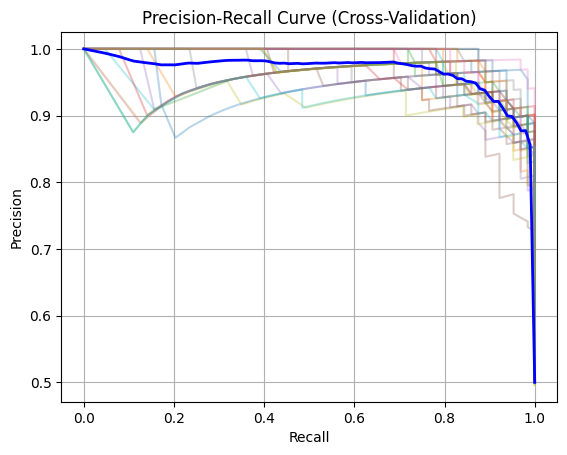

Sample y_test values: Class/ASD
0    639
1    161
Name: count, dtype: int64
Sample y_pred values: 0    633
1    167
Name: count, dtype: int64
Sample sensitive_feature values: gender
1    530
0    270
Name: count, dtype: int64
X_test shape: (800, 85)
Model expects: 85
Group-wise Precision and Recall:
        Precision    Recall
gender                     
0        0.932203  1.000000
1        0.972222  0.990566
Δ Recall is within acceptable limits. No mitigation needed.


In [14]:
# Run the Random Forest model notebook to load the model and data
%run SupervisedRandomForest.ipynb

# Evaluate metrics using the simulated target variable
metric_frame, X_test, y_test = evaluate_group_metrics(rf_model, sensitive_feature)
calculate_difference(rf_model, X_test, y_test, metric_frame, 'Recall')


Mean ROC-AUC: 0.9720930472883598 (95% CI: 0.9672614301347551, 0.9769246644419645)
Mean PR-AUC: 0.4671730691414756 (95% CI: 0.46051606829620356, 0.47383006998674765)
Mean F1 Score: 0.9185654200258261 (95% CI: 0.9098000968595783, 0.9273307431920739)
Mean Matthews Correlation Coefficient: 0.8342036238630663 (95% CI: 0.8160131601249783, 0.8523940876011544)


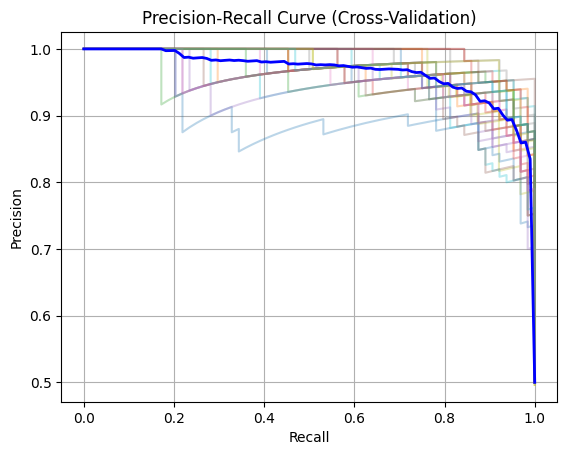

Sample y_test values: Class/ASD
0    639
1    161
Name: count, dtype: int64
Sample y_pred values: 0    610
1    190
Name: count, dtype: int64
Sample sensitive_feature values: gender
1    530
0    270
Name: count, dtype: int64
X_test shape: (800, 85)
Model expects: 85
Group-wise Precision and Recall:
        Precision    Recall
gender                     
0        0.803030  0.963636
1        0.814516  0.952830
Δ Recall is within acceptable limits. No mitigation needed.


In [15]:
# Run the Cat Boost model notebook to load the model and data
%run SupervisedCatBoost.ipynb

# Evaluate metrics using the simulated target variable
metric_frame, X_test, y_test = evaluate_group_metrics(catboost_model, sensitive_feature)
calculate_difference(catboost_model, X_test, y_test, metric_frame, 'Recall')


Mean ROC-AUC: 0.792
Mean F1 Score: 0.629
Mean MCC Score: 0.530


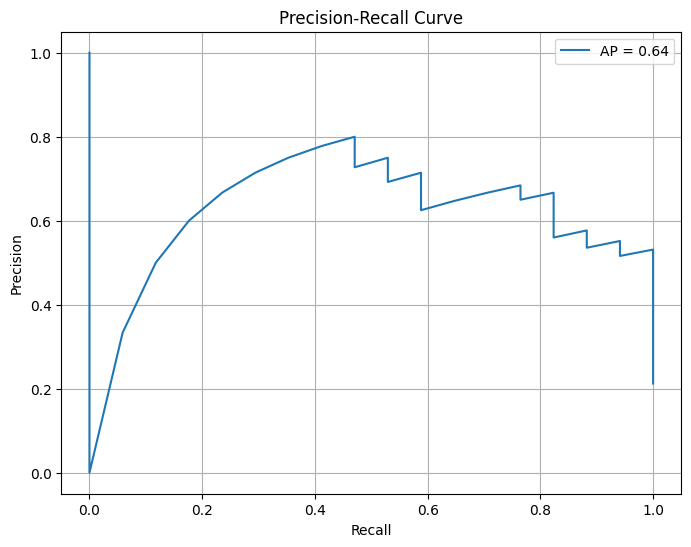

Sample y_test values: Simulated_Class/ASD
1    200
Name: count, dtype: int64
Sample y_pred values: 1    200
Name: count, dtype: int64
Sample sensitive_feature values: gender
1    125
0     75
Name: count, dtype: int64
Rows predicted as Class/ASD (1):
     A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0           1         1         0         0         1         1         0   
1           1         0         0         0         0         0         0   
2           1         1         1         0         1         1         0   
3           0         0         0         0         0         0         0   
4           0         0         0         1         0         0         0   
..        ...       ...       ...       ...       ...       ...       ...   
195         1         1         0         0         1         0         0   
196         1         0         0         0         0         0         0   
197         1         0         0         0         0   

In [10]:
# Run the Logistic Regression model notebook to load the model and data
%run SupervisedlogisticRegression.ipynb

# Evaluate metrics using the simulated target variable
metric_frame, X_test, y_test = evaluate_group_metrics(model, sensitive_feature)
calculate_difference(model, X_test, y_test, metric_frame, 'Recall')


ROC-AUC: 0.8779 (95% CI: 0.8428, 0.9290)
PR-AUC: 0.6227
F1 Score: 0.5957
Matthews CC: 0.5052


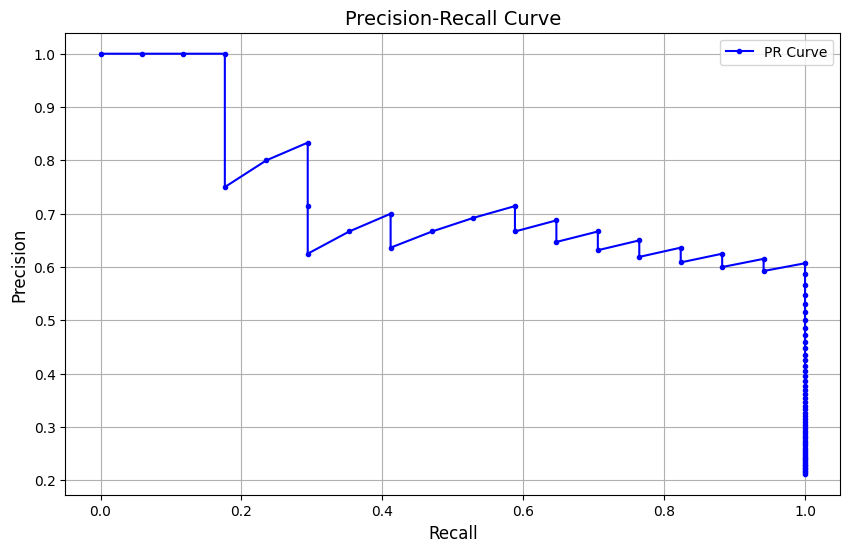

Sample y_test values: Class/ASD
0    639
1    161
Name: count, dtype: int64
Sample y_pred values: 0    639
1    161
Name: count, dtype: int64
Sample sensitive_feature values: gender
1    530
0    270
Name: count, dtype: int64
X_test shape: (800, 85)
Model expects: 85
Group-wise Precision and Recall:
        Precision    Recall
gender                     
0        0.962963  0.945455
1        0.962617  0.971698
Δ Recall is within acceptable limits. No mitigation needed.


In [62]:
# Run the XG Boost model notebook to load the model and data
%run SupervisedXGBoost.ipynb

# Evaluate metrics using the simulated target variable
metric_frame, X_test, y_test = evaluate_group_metrics(xgb_model, sensitive_feature)
calculate_difference(xgb_model, X_test, y_test, metric_frame, 'Recall')
